## LeNet5

### 引入相關python模組

In [1]:
from mycnn import LeNet5
from mycnn import utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 讀取Keras內建的MNIST資料集，採用NumPy Array的形式

#### 預處理

1. 重塑陣列形狀 784 => 28x28x1
2. 填充矩陣 28x28x1 => 32x32x1
3. 重新縮放數值比例至 0 ~ 1 (正規化)
4. 標記資料進行 One-Hot Encoeing

> Note:  
> 我使用 Keras 裡預設的資料集來載入 MNIST 數字集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape 784 to 28x28x1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# pad image from 28x28x1 to 32x32x1
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)))
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)))
print(x_train.shape)
print(x_test.shape)

# convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


### 確認資料

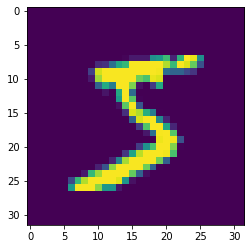

Check One-Hot Encoding
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [3]:
plt.imshow(x_train[0,:,:,0])
plt.show()
print("Check One-Hot Encoding")
print(y_train[0])

### 載入LeNet-5模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

> Note:  
> 這裡呼叫的 LeNet5() 等同於用 tf.kera.Model 建構的模型實例  
> 只是在此類中又多加了我自己的一些方法，同時將一些方法  
> (並不是用繼承的方式，而是將模型實例保存在類別屬性中)

In [4]:
cnn = LeNet5(
    input_shape=(32,32,1),
    classes_num=10
)
cnn.summary()

Model: "LeNet5"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 32, 32, 1)]                             0                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, 28, 28, 6)                               156               
                                                                                                                        
 average_pooling2d (AveragePooling2D)                 (None, 14, 14, 6)                               0                 
                                                                                                                        
 conv2d_1 (Conv2

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

> Note:  
> 原始 Keras 的會用到 `compile()`，這裡我將其封裝一個新方法，並額外設定其他與訓練相關的參數  
> 
> `compile()` 主要會去設定優化器 (optimizer)、損失函數 (loss function)、評估函數 (metric function)  
> 這邊額外設定訓練相關檔案的儲存路徑、訓練週期 (epochs)、批次大小 (batch size)、回調函數 (callback)

In [5]:
cnn.setup_training(
    logdir='log_lenet5',
    epochs=10,
    batch_size=100,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, decay=0.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

[Info] Create new the directory for training log !!!!!
******************************
Training new model...
******************************
checkpoint_path : log_lenet5\weights
best_checkpoint : log_lenet5\weights.h5
epochs          : 10
initial_epoch   : 0
batch_size      : 100
optimizer       : {'name': 'SGD', 'learning_rate': 0.1, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練影像資料、訓練標記資料、驗證影像資料、驗證標記資料

此範例將前五萬筆資料作為訓練資料，後一萬筆用來驗證模型分類效能

> Note:  
> 原始 Keras 的訓練方法為 `fit()`，這裡我將其封裝一個新方法 `train()`  
> 用來輸入 NumPy Array，分為訓練資料及驗證資料

In [6]:
cnn.train(x_train[:50000], y_train[:50000], x_train[50000:], y_train[50000:])

Epoch 1/10
493/500 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8952
Epoch 00001: val_loss improved from inf to 0.15895, saving model to log_lenet5\weights.h5
500/500 [==============================] - 12s 10ms/step - loss: 0.3703 - accuracy: 0.8959 - val_loss: 0.1590 - val_accuracy: 0.9567
Epoch 2/10
497/500 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9584
Epoch 00002: val_loss improved from 0.15895 to 0.10404, saving model to log_lenet5\weights.h5
500/500 [==============================] - 6s 12ms/step - loss: 0.1398 - accuracy: 0.9585 - val_loss: 0.1040 - val_accuracy: 0.9686
Epoch 3/10
498/500 [============================>.] - ETA: 0s - loss: 0.0939 - accuracy: 0.9723
Epoch 00003: val_loss improved from 0.10404 to 0.08511, saving model to log_lenet5\weights.h5
500/500 [==============================] - 5s 10ms/step - loss: 0.0939 - accuracy: 0.9724 - val_loss: 0.0851 - val_accuracy: 0.9745
Epoch 4/10
496/500 [=================

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

> Note:  
> 會自動從儲存路徑讀取訓練過程表，然後繪製對應的曲線

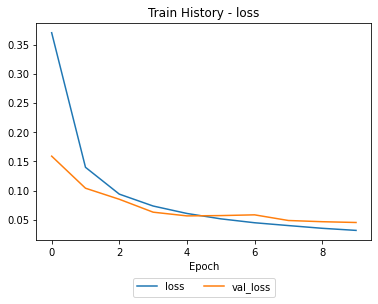

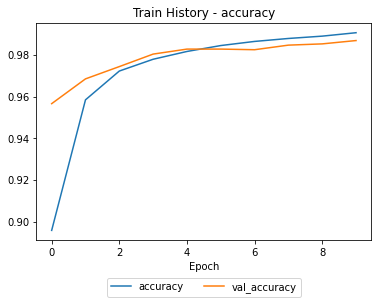

In [7]:
cnn.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

> Note:  
> 原始 Keras 的訓練方法為 `evaluate()`，這裡我將其封裝一個新方法 `eval()`  
> `eval()` 用法與 `evaluate()` 大致相同，只是會自動設定批次大小，只需要輸入資料即可

In [8]:
cnn.eval(x_test, y_test)

100/100 [==============================] - 1s 5ms/step - loss: 0.0368 - accuracy: 0.9881


[0.036764487624168396, 0.988099992275238]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
> recall: 召回率，在所有GT中，真正預測出TP的指標  
> precision: 精確率，在所有預測結果中，真正為TP的指標  
> (GT: 真實情況；TP: 正樣本)

####

> Note:  
> 原始 Keras 的訓練方法為 `predict()`，這裡我將其封裝一個新方法 `pred()`  
> `pred()` 用法與 `predict()` 大致相同，只是會自動設定批次大小，只需要輸入資料即可

100%|██████████| 10000/10000 [00:00<00:00, 86206.77it/s]


[[ 973    0    0    0    0    0    2    1    2    2]
 [   0 1128    1    0    0    1    2    2    1    0]
 [   2    0 1023    1    1    0    0    4    1    0]
 [   0    0    5  992    0    4    0    2    2    5]
 [   0    0    1    0  970    0    4    0    1    6]
 [   3    0    0    3    0  880    4    1    1    0]
 [   1    2    0    0    2    3  950    0    0    0]
 [   0    1    5    2    0    0    0 1013    1    6]
 [   3    0    3    2    2    1    0    2  958    3]
 [   1    1    0    1    7    1    0    3    1  994]] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99 

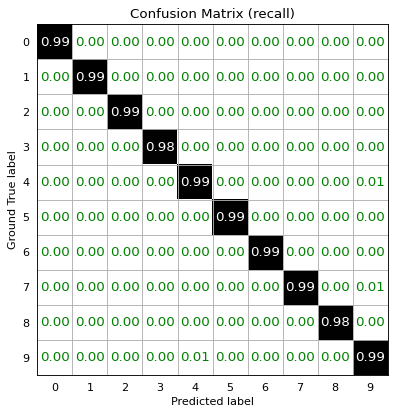

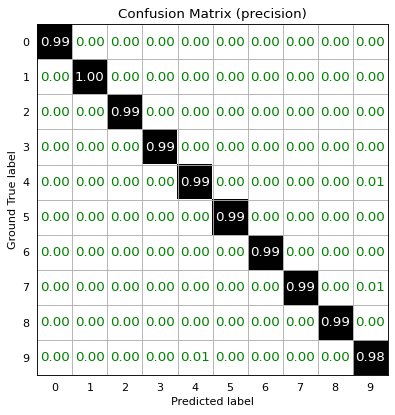

In [9]:
pr_score = cnn.pred(x_test)
pr_label = pr_score.argmax(axis=-1)
gt_label = y_test.argmax(axis=-1)

target_names = [str(i) for i in range(10)]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=cnn.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, cnn.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, cnn.logdir, title='Confusion Matrix (precision)')

### 預測單筆資料

這裡我使用原始 Keras 方法 `predict()` 進行單張預測

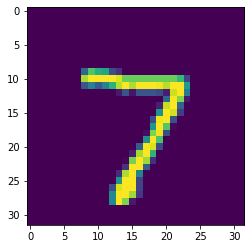


[Info] Use `tf.keras.Model` method predict

Score:
[4.7882072e-06 1.0943578e-06 6.2853818e-05 5.4065742e-05 8.0601694e-08
 6.2486902e-07 5.3041121e-10 9.9986446e-01 4.1062179e-07 1.1651517e-05]
Label: 7


In [10]:
data_id = 0

pr_data = x_test[data_id:data_id+1,...]  # only choice one data
plt.imshow(pr_data[0,:,:,0])
plt.show()

pr_sc = cnn.predict(pr_data)
pr_lb = pr_sc.argmax(axis=-1)
print("Score:")
print(pr_sc[0])
print("Label:", pr_lb[0])